<a id='TOP'></a>
<div class="alert alert-block alert-warning">

# Machine Learning with Text in scikit-learn
<u>Clasificación: aprendizaje supervisado<br>240 documentos difundidos por el Banco Mundial relacionados con inversiones en Filipinas <br></u>

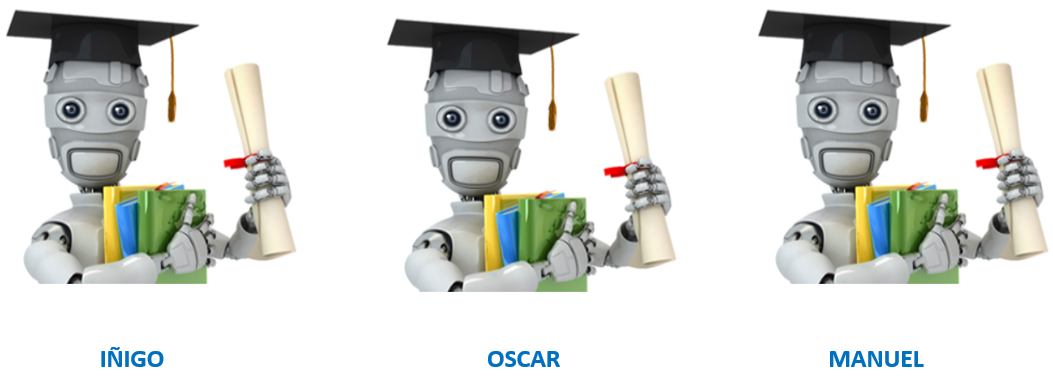

# Índice

1. [Localización y carga de los documentos](#Localización)

2. [Extracción de texto y ajustes](#Extracción)

3. [Matriz de Características y Vector de Categorias](#MatrizYVector)


4. [Aprendizaje Supervisado](#SUPERVISADO)

   4.1. [Vectorización](#VECTORIZACIÓN)
   
   4.2. [**Multinomial Naive Bayes**](#MNB)
   
      ___4.2.1. [Validación cruzada en MNB](#VCMNB)
      
      ___4.2.2. [Curvas ROC MNB](#ROCMNB)
   
   4.3. [**K Nearest Neighbors**](#KNN)
   
      ___4.3.1. [Validación cruzada en KNN](#VCKNN)
      
      ___4.3.2. [CURVAS ROC KNN](#ROCKNN)
   
   4.4. [**Regresión Logística**](#RL)
   
      ___4.4.1. [Validación cruzada en RL](#VCRL)
      
      ___4.4.2. [CURVAS ROC RL](#ROCRL)


5. [Cuadro Resumen del Rendimiento de los modelos](#CUADRORESUMEN)

6. [Predicción con nuevos documentos](#PREDICCIONOUTOFSAMPE)

<div class="alert alert-block alert-warning">

# Preprocesamiento

<a id='Localización'></a>
<div class="alert alert-block alert-info">

## 1. Localización y carga de PDFs

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# PASO 1
# crear 2 listas; una con el nombre y extensión de los documentos y otra con su ubicación 'virtual'
# antes cambiamos nuestro directorio de trabajo a aquel en el qué estén los documentos a clasificar
import os
os.chdir('C:/Users/IÑIGO/Documents/WORLDBANK/TEST/PDFs')
mypath=os.getcwd()

List_Documents=[]
ListDirDocuments=[]

for (root, directories, filenames) in os.walk(mypath):
    for f in filenames:
                
        List_Documents.append(os.path.join(f))
        List_Documents=list(filter(lambda x: (x.endswith('pdf')), List_Documents))
        #===============================================================================
        ListDirDocuments.append(os.path.join(root,f).replace('\\','/'))
        ListDirDocuments=list(filter(lambda x: (x.endswith('pdf')), ListDirDocuments))

# PASO 2
# crear otra LISTA CON EL NUMERO DE PAGINAS DE CADA PDF

from PyPDF2 import PdfFileReader
NumberOfPagesList=[]
for i in range(0,len(ListDirDocuments)):
    
    NumberOfPagesList.append(PdfFileReader(stream=ListDirDocuments[i]).getNumPages()) 
    
# PASO 3
# Combinar toda la información extraida hasta ahora en una Matriz "pandas" --df1--
import pandas as pd
pd.set_option('display.max_colwidth',1000)
df1=pd.DataFrame({'Nombre_Documento':List_Documents,
                  'Ubicación':ListDirDocuments,
                'Número de Páginas':NumberOfPagesList})
df1=df1[['Nombre_Documento','Número de Páginas','Ubicación']]
df1.head()
df1.shape

,Nombre_Documento,Número de Páginas,Ubicación
0,Appraisal__ISDS--08-28-2014.pdf,14,C:/Users/IÑIGO/Documents/WORLDBANK/TEST/PDFs/Cebu Bus Rapid Transit (BRT) Project/Appraisal__ISDS--08-28-2014.pdf
1,Audited Financial Statements -CY2017.pdf,20,C:/Users/IÑIGO/Documents/WORLDBANK/TEST/PDFs/Cebu Bus Rapid Transit (BRT) Project/Audited Financial Statements -CY2017.pdf
2,Audited Financial Statements -CY2017_Fd.pdf,20,C:/Users/IÑIGO/Documents/WORLDBANK/TEST/PDFs/Cebu Bus Rapid Transit (BRT) Project/Audited Financial Statements -CY2017_Fd.pdf
3,Cebu-BRT-Audited Financial Statements-CY2016.pdf,20,C:/Users/IÑIGO/Documents/WORLDBANK/TEST/PDFs/Cebu Bus Rapid Transit (BRT) Project/Cebu-BRT-Audited Financial Statements-CY2016.pdf
4,Cebu-BRT-Audited Financial Statements-CY2016_b.pdf,20,C:/Users/IÑIGO/Documents/WORLDBANK/TEST/PDFs/Cebu Bus Rapid Transit (BRT) Project/Cebu-BRT-Audited Financial Statements-CY2016_b.pdf


(210, 3)

<a id='Extracción'></a>
<div class="alert alert-block alert-info">

## 2. EXTRACCIÓN DEL TEXTO DE LOS DOCUMENTOS

In [3]:
# PASO 4
# LISTA CON EL TEXTO DE TODAS LAS PAGINAS DE CADA PDF
# lEE 210 PDFs y extrae el texto de once mil doscientos setenta y cuatro (11.274) páginas

from PyPDF2 import PdfFileReader
TextExtractionList=[]

for i in range(0,len(ListDirDocuments)):
    
    read_pdf=PdfFileReader(ListDirDocuments[i])
    number_of_pages = read_pdf.getNumPages()
    for page_number in range(number_of_pages):
        page = read_pdf.getPage(page_number)
        page_content = page.extractText()
        
        TextExtractionList.append(page_content)
    
# PASO 5
# A continuación redimensionamos "TextExtractionList" de 11.274 filas a 210 filas
TEL = []
c = 0
for np in NumberOfPagesList:       
    LP = TextExtractionList[c:c+np]
    c+= np
    TEL.append(LP)
    
# PASO 6
# Modificamos TEL para que todos sus elementos sean una única cadena de texto
TELstr=[] #===========================
for i in range(len(TEL)):
    TELstr.append(" ".join(TEL[i]))
    
# PASO 7 
# Combinar toda la información extraida hasta ahora en una nueva Matriz "pandas" df2
df2=pd.DataFrame({'Documento':List_Documents,
                  'AllRawText':TELstr,
                 'Num.Páginas':NumberOfPagesList})
df2.shape
pd.set_option('max_colwidth', 1000)
df2.iloc[6:9,0:2]

(210, 3)

,Documento,AllRawText
6,Cebu-Bus-Rapid-Transit-BRT-Project-Procurement-Plan.pdf,Attachment A\nCebu Bus Rapid Transit\nProcurement Plan\nAs of 26 February 2018 \nI.General\n1.\nBank™s approval Date of the Procurement Plan: \n Bank no objection to \noriginal procurement plan was issued on 31 July 2014;This version submitted \nto Bank for approval on 27 February 2017.\n2.\nDate of General Procurement Notice\n: 29 August 2012\n3.\nPeriod covered by this procurement plan\n: January 2017 - January 2018\nII.\nGoods and Works and Non-consulting services\n1.\nPrior Review Threshold\n: Procurement Decisions subject to Prior Review by \nthe Bank as stated in Appendix 1 to the Guidelines for Procurement: \nProcurement Method\nMethod \nThreshold US$\nPrior Review \nThreshold\nUS$\n1.\nICB (Goods) \n3m and above\nAll contracts\n2.\nNCB (Goods) packages\nless than 3m \n2m and above\n3.\nShopping (Goods)\nLess than 0.1m\nNone\n4.\nICB (Works) packages\n15m and above\nAll contracts\n5.\nNCB (Works) packages\nLess than 15m \n10m and above\n6.\nShopping (Works)\nLess than 0.2m\...
7,Cebu-Bus-Rapid-Transit-BRT-Project-Procurement-Plan_.pdf,Attachment A\nCebu Bus Rapid Transit\nProcurement Plan\nAs of 26 February 2018 \nI.General\n1.\nBank™s approval Date of the Procurement Plan: \n Bank no objection to \noriginal procurement plan was issued on 31 July 2014;This version submitted \nto Bank for approval on 27 February 2017.\n2.\nDate of General Procurement Notice\n: 29 August 2012\n3.\nPeriod covered by this procurement plan\n: January 2017 - January 2018\nII.\nGoods and Works and Non-consulting services\n1.\nPrior Review Threshold\n: Procurement Decisions subject to Prior Review by \nthe Bank as stated in Appendix 1 to the Guidelines for Procurement: \nProcurement Method\nMethod \nThreshold US$\nPrior Review \nThreshold\nUS$\n1.\nICB (Goods) \n3m and above\nAll contracts\n2.\nNCB (Goods) packages\nless than 3m \n2m and above\n3.\nShopping (Goods)\nLess than 0.1m\nNone\n4.\nICB (Works) packages\n15m and above\nAll contracts\n5.\nNCB (Works) packages\nLess than 15m \n10m and above\n6.\nShopping (Works)\nLess than 0.2m\...
8,Cebu-Bus-Rapid-Transit-BRT-Project-Procurement-Plan_attach.pdf,Attachment A\nCebu Bus Rapid Transit\nProcurement Plan\nAs of 26 February 2018 \nI.General\n1.\nBank™s approval Date of the Procurement Plan: \n Bank no objection to \noriginal procurement plan was issued on 31 July 2014;This version submitted \nto Bank for approval on 27 February 2017.\n2.\nDate of General Procurement Notice\n: 29 August 2012\n3.\nPeriod covered by this procurement plan\n: January 2017 - January 2018\nII.\nGoods and Works and Non-consulting services\n1.\nPrior Review Threshold\n: Procurement Decisions subject to Prior Review by \nthe Bank as stated in Appendix 1 to the Guidelines for Procurement: \nProcurement Method\nMethod \nThreshold US$\nPrior Review \nThreshold\nUS$\n1.\nICB (Goods) \n3m and above\nAll contracts\n2.\nNCB (Goods) packages\nless than 3m \n2m and above\n3.\nShopping (Goods)\nLess than 0.1m\nNone\n4.\nICB (Works) packages\n15m and above\nAll contracts\n5.\nNCB (Works) packages\nLess than 15m \n10m and above\n6.\nShopping (Works)\nLess than 0.2m\...


In [14]:
# PASO 8
# feature selection
# creamos una nueva Matriz añadiendo una columna nueva con el texto depurado de todos los caracteres que no sean letras
# a continuación procesamos los tokens resultantes extrayendo sus 'raíces' - "Stemming"

from nltk.stem import SnowballStemmer
stemmer=SnowballStemmer("english")
from nltk.corpus import stopwords
WordsStoped=stopwords.words("english")

import re # un poco de REGEX
#eliminar todo que no sea texto
SoloTexto = re.compile(r'[^a-zA-Z]')
df2['Texto_Procesado']=df2.AllRawText.apply(lambda col: " ".join(SoloTexto.sub(' ',col).split()))
#eliminar tokens con tres o menos palabras
ShortWords = re.compile(r'\W*\b\w{1,3}\b')
df2['Texto_Procesado']=df2['Texto_Procesado'].apply(lambda col: " ".join(ShortWords.sub('',col).split()))
#extracción de raices
df2['Texto_Procesado']=df2['Texto_Procesado'].apply\
(lambda x: " ".join([stemmer.stem(i) for i in x.split() if i not in WordsStoped]).lower())

#df2['Texto_Procesado']=df2['Texto_Procesado'].apply\
#(lambda x: " ".join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]'," ",x).split() if i not in WordsStoped]).lower())

df2=df2[['Documento','Texto_Procesado','AllRawText','Num.Páginas']]
df2.iloc[6:9,0:2]

,Documento,Texto_Procesado
6,Cebu-Bus-Rapid-Transit-BRT-Project-Procurement-Plan.pdf,attach cebu rapid transit procur plan februari general bank approv date procur plan bank object origin procur plan issu juli this version submit bank approv februari date general procur notic august period cover procur plan januari januari good work consult servic prior review threshold procur decis subject prior review bank state appendix guidelin procur procur method method threshold prior review threshold good contract good packag less shop good less none work packag contract work packag less shop work less none refer project oper procur manual final march other special procur arrang advanc procur follow bank procur guidelin summari procur packag includ subject retroact financ advanc procur descript estim cost million fund sourc procur agenc procur method domest prefer review bank prior post expect open date note date revis current project status sequenc ment public disclosur author public disclosur author public disclosur author public disclosur author retain previous procur me...
7,Cebu-Bus-Rapid-Transit-BRT-Project-Procurement-Plan_.pdf,attach cebu rapid transit procur plan februari general bank approv date procur plan bank object origin procur plan issu juli this version submit bank approv februari date general procur notic august period cover procur plan januari januari good work consult servic prior review threshold procur decis subject prior review bank state appendix guidelin procur procur method method threshold prior review threshold good contract good packag less shop good less none work packag contract work packag less shop work less none refer project oper procur manual final march other special procur arrang advanc procur follow bank procur guidelin summari procur packag includ subject retroact financ advanc procur descript estim cost million fund sourc procur agenc procur method domest prefer review bank prior post expect open date note date revis current project status sequenc ment public disclosur author public disclosur author public disclosur author public disclosur author retain previous procur me...
8,Cebu-Bus-Rapid-Transit-BRT-Project-Procurement-Plan_attach.pdf,attach cebu rapid transit procur plan februari general bank approv date procur plan bank object origin procur plan issu juli this version submit bank approv februari date general procur notic august period cover procur plan januari januari good work consult servic prior review threshold procur decis subject prior review bank state appendix guidelin procur procur method method threshold prior review threshold good contract good packag less shop good less none work packag contract work packag less shop work less none refer project oper procur manual final march other special procur arrang advanc procur follow bank procur guidelin summari procur packag includ subject retroact financ advanc procur descript estim cost million fund sourc procur agenc procur method domest prefer review bank prior post expect open date note date revis current project status sequenc ment public disclosur author public disclosur author public disclosur author public disclosur author retain previous procur me...


<a id='MatrizYVector'></a>
<div class="alert alert-block alert-info">

## 3. Obtención de la matriz de características (X) y el vector de categorias (y)

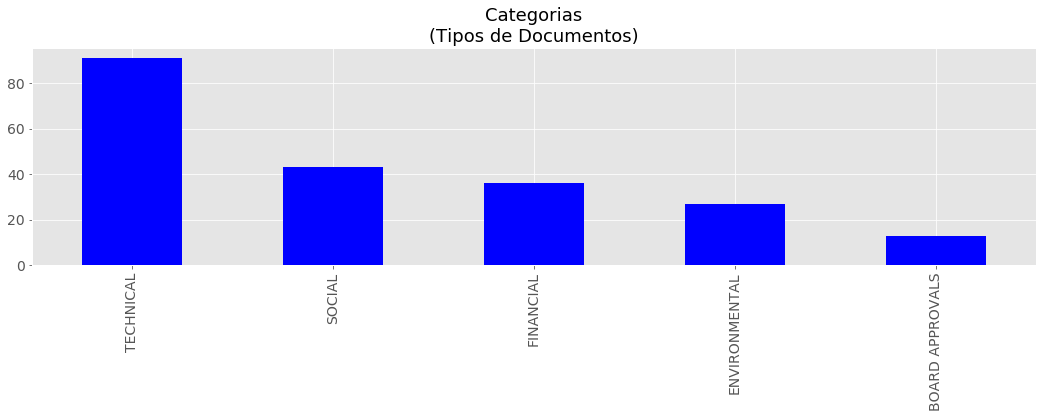

In [15]:
# PASO 9a - IMPORTAMOS EL FICHERO
# A continuación asignamos a cada PDF su "categoria" desde (World_Bank_Documents_Classification_P.xlsm)
# En este Excel se encuentra la clasificación manual de los 210 documentos
import os
os.chdir('C:/Users/IÑIGO/Documents/InfoNoEstructurada_ProcesamientoLenguajeNatural_TextMining/TRABAJO FIN DE MASTER')
import pandas as pd
worldbank=pd.read_excel('World_Bank_Documents_Classification_P.xlsm',
                        sheet_name='WBD_PHILIPPINES_CLASSIFICATION',
                        skiprows=7, 
                        usecols=[0,1,2,3,4,5,6,7,8,9,10])

# 9b -VISUALIZACIÓN DE LAS 5 CATEGORIAS
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

grafica_types= worldbank.Type.value_counts()

ax=grafica_types.plot(kind='bar',
                      figsize=(18,4),
                      fontsize=14,
                      color="blue")

ax.set_title('Categorias\n(Tipos de Documentos)',fontsize=18, color="black");
ax.set_ylabel('',fontsize=16, color="brown");
ax.set_xlabel('',fontsize=18, color="brown");

In [17]:
# 9c - Fusionamos todo en una nueva matriz "pandas" para poder extraer de ella el vector de atributos (X) y vector de categorias (y)
MERGED=df2.join([worldbank.Type])
MERGED=MERGED[['Documento','Num.Páginas','Type','AllRawText','Texto_Procesado']]
MERGED.shape
MERGED.set_index('Documento').iloc[1:3,1:4]

(210, 5)

,Type,AllRawText,Texto_Procesado
Documento,,,
Audited Financial Statements -CY2017.pdf,FINANCIAL,"AUDITED FINANCIAL STATEMENTS\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\n Republic of the PhilippinesCOMMISSION ON AUDITCommonwealth Avenue, Quezon City, Philippinesr""FEINDEPENDENT AUDITOR'S REPORTThe SecretaryDepartment of TransportationClark Freeport Zone, Mabalacat, PampangaWe have audited the accompanying financial statements of the Cebu Bus Rapid Transit(BRT) Project financed under the International Bank for Reconstruction andDevelopment (IBRD) Loan No. 8444-PH of the World Bank, including CleanTechnology Fund Loan No. TF017646-PH, and Credit Facility Agreement with theAgence Francaise de Developpement, and implemented by the Department ofTransportation -Central Office (DOTr -CO), which comprise the Statement ofFinancial Position as of December 31, 2017, and the related Statement of FinancialPerformance, Cash Flows, Changes in Net Assets/Equity and Comparison of Budget andActual Amounts and Statement ...",audit financi statement public disclosur author public disclosur author public disclosur author public disclosur author republ philippinescommiss auditcommonwealth avenu quezon citi philippinesr feindepend auditor reportth secretarydepart transportationclark freeport zone mabalacat pampangaw audit accompani financi statement cebu rapid transit project financ intern bank reconstruct anddevelop ibrd loan world bank includ cleantechnolog fund loan credit facil agreement theagenc francais developp implement depart oftransport central offic dotr compris statement offinanci posit decemb relat statement financialperform cash flow chang asset equiti comparison budget andactu amount statement sourc use fund year end summari signific account polici explanatori inform manag respons financi statementsmanag respons prepar fair present financialstat accord philippin public sector account standard ppsas intern control manag determin necessari enabl theprepar financi statement free materi misstat ...
Audited Financial Statements -CY2017_Fd.pdf,FINANCIAL,"AUDITED FINANCIAL STATEMENTS\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\nPublic Disclosure Authorized\n Republic of the PhilippinesCOMMISSION ON AUDITCommonwealth Avenue, Quezon City, Philippinesr""FEINDEPENDENT AUDITOR'S REPORTThe SecretaryDepartment of TransportationClark Freeport Zone, Mabalacat, PampangaWe have audited the accompanying financial statements of the Cebu Bus Rapid Transit(BRT) Project financed under the International Bank for Reconstruction andDevelopment (IBRD) Loan No. 8444-PH of the World Bank, including CleanTechnology Fund Loan No. TF017646-PH, and Credit Facility Agreement with theAgence Francaise de Developpement, and implemented by the Department ofTransportation -Central Office (DOTr -CO), which comprise the Statement ofFinancial Position as of December 31, 2017, and the related Statement of FinancialPerformance, Cash Flows, Changes in Net Assets/Equity and Comparison of Budget andActual Amounts and Statement ...",audit financi statement public disclosur author public disclosur author public disclosur author public disclosur author republ philippinescommiss auditcommonwealth avenu quezon citi philippinesr feindepend auditor reportth secretarydepart transportationclark freeport zone mabalacat pampangaw audit accompani financi statement cebu rapid transit project financ intern bank reconstruct anddevelop ibrd loan world bank includ cleantechnolog fund loan credit facil agreement theagenc francais developp implement depart oftransport central offic dotr compris statement offinanci posit decemb relat statement financialperform cash flow chang asset equiti comparison budget andactu amount statement sourc use fund year end summari signific account polici explanatori inform manag respons financi statementsmanag respons prepar fair present financial

In [19]:
# 9d -EMPAQUETAMOS vector de atributos (X) y vector de categorias (y)
X = MERGED['Texto_Procesado'] # pandas Series con el TEXTO extraido de cada PDF
y = MERGED.Type # pandas Series con las CLASIFICACIONES (LABELs)
# 9e -Listado de las 5 categorias de (y) y su distribución
pd.options.display.float_format = '{:.1f}%'.format
categorias=pd.DataFrame({'Repeticiones':y.value_counts()})
categorias['Porcentaje']=(categorias['Repeticiones']/categorias.Repeticiones.sum())*100
nueva_fila={'Repeticiones':y.value_counts().sum(),'Porcentaje':'100%'}
categorias=categorias.append(nueva_fila, ignore_index=True)
categorias.index=['TECHNICAL','SOCIAL','FINANCIAL','ENVIRONMENTAL','BOARD_APPROVALS','TOTAL']
categorias

,Repeticiones,Porcentaje
TECHNICAL,91,43.3%
SOCIAL,43,20.5%
FINANCIAL,36,17.1%
ENVIRONMENTAL,27,12.9%
BOARD_APPROVALS,13,6.2%
TOTAL,210,100%


[VOLVER AL ÍNDICE](#TOP)

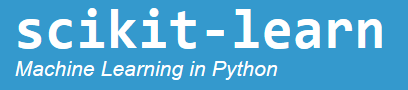

<a id='SUPERVISADO'></a>
<div class="alert alert-block alert-info">

# 4. APRENDIZAJE SUPERVISADO

DIVISIÓN DE LOS DOCUMENTOS EN BLOQUES PARA ENTRENAR LOS MODELOS Y PROBAR LOS RESULTADOS

In [20]:
# PASO 10
# Ahora dividimos 'X' e 'y' una única vez en 2 sub-matrices para "ENTRENAR" y "PROBAR" los modelos de clasificación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=123,test_size=0.25, train_size=0.75)
pd.DataFrame({'X=matriz de atributos':[len(X_train),len(X_test)],
                  'y=vector de categorias':[len(y_train),(len(y_test))]},index=['Entrenamiento (75%)','Prueba (25%)'])

,X=matriz de atributos,y=vector de categorias
Entrenamiento (75%),157,157
Prueba (25%),53,53


<a id='VECTORIZACIÓN'></a>
<div class="alert alert-block alert-success">

## 4.1 VECTORIZACIÓN (Transformación de texto en vectores numéricos)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=5,
                       max_df=0.85,
                       stop_words='english')
X_train_dtm = vect.fit_transform(X_train) #
X_train_dtm
X_test_dtm = vect.transform(X_test) #
X_test_dtm

<157x5723 sparse matrix of type '<class 'numpy.int64'>'
	with 106104 stored elements in Compressed Sparse Row format>

<53x5723 sparse matrix of type '<class 'numpy.int64'>'
	with 35523 stored elements in Compressed Sparse Row format>

<a id='MNB'></a>
<div class="alert alert-block alert-success">

## 4.2 CLASIFICACIÓN CON `Multinomial Naive Bayes`

In [22]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

from sklearn import metrics
Accuracy_MNB=round(metrics.accuracy_score(y_test, y_pred_class),4)
print("La clasificación realizada por **Multinomial Naive Bayes** consigue un rendimiento de {:.1f}%".format(Accuracy_MNB*100))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

La clasificación realizada por **Multinomial Naive Bayes** consigue un rendimiento de 83.0%


In [23]:
# comprobación intuitiva del accuracy obtenido por caja negra scikit-learn
cm=pd.DataFrame(data={'Esperado':y_test,'Predicho':y_pred_class}) #cm=comprobación manual
cm['¿Son_Iguales?'] =cm.apply(lambda Columna: Columna['Esperado'] in Columna['Predicho'], axis=1)
accur=cm['¿Son_Iguales?'].sum()/len(cm['¿Son_Iguales?'])
print("El rendimiento calculado adhoc también es {:.1f}%".format(accur*100))
cm.head(10)

El rendimiento calculado adhoc también es 83.0%


,Esperado,Predicho,¿Son_Iguales?
173,TECHNICAL,TECHNICAL,True
178,TECHNICAL,TECHNICAL,True
182,TECHNICAL,TECHNICAL,True
132,FINANCIAL,FINANCIAL,True
190,TECHNICAL,TECHNICAL,True
196,ENVIRONMENTAL,ENVIRONMENTAL,True
199,TECHNICAL,TECHNICAL,True
171,SOCIAL,SOCIAL,True
95,ENVIRONMENTAL,ENVIRONMENTAL,True
31,ENVIRONMENTAL,ENVIRONMENTAL,True


In [24]:
#'rendimiento' de clasificación NULO...el rendimiento que se consigue prediciendo siempre la categoria más frecuente
RCN=pd.DataFrame({'Esperado': y_test,'SIEMPRE_TECHNICAL':'TECHNICAL'})
RCN['¿Son_Iguales?'] =RCN.apply(lambda Columna: Columna['Esperado'] in Columna['SIEMPRE_TECHNICAL'], axis=1)
accur_rcn=RCN['¿Son_Iguales?'].sum()/len(RCN['¿Son_Iguales?'])
print("El rendimiento NULO es {:.1f}%".format(accur_rcn*100))
RCN.head()

El rendimiento NULO es 49.1%


,Esperado,SIEMPRE_TECHNICAL,¿Son_Iguales?
173,TECHNICAL,TECHNICAL,True
178,TECHNICAL,TECHNICAL,True
182,TECHNICAL,TECHNICAL,True
132,FINANCIAL,TECHNICAL,False
190,TECHNICAL,TECHNICAL,True


In [25]:
round(y_test.value_counts()[0]/len(y_test)*100,1)

49.1

CONCLUSIÓN: <BR>Un RENDIMIENTO de 83% se puede considerar muy bueno. APLAUSOS.

In [26]:
# Matriz de confusión========= conjunto de prueba ======53 documentos=======
# The confusion matrix shows the ways in which your classification model is confused when it makes predictions
from sklearn.metrics import confusion_matrix
metrics.confusion_matrix(y_test, y_pred_class)
metrics.confusion_matrix(y_test, y_pred_class)[4,:].sum()
metrics.confusion_matrix(y_test, y_pred_class).sum()

array([[ 2,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  2],
       [ 1,  0,  4,  0,  2],
       [ 0,  0,  0,  8,  3],
       [ 0,  1,  0,  0, 25]], dtype=int64)

26

53

In [27]:
nb.classes_

array(['BOARD APPROVALS', 'ENVIRONMENTAL', 'FINANCIAL', 'SOCIAL',
       'TECHNICAL'], dtype='<U15')

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_class))

                 precision    recall  f1-score   support

BOARD APPROVALS       0.67      1.00      0.80         2
  ENVIRONMENTAL       0.83      0.71      0.77         7
      FINANCIAL       1.00      0.57      0.73         7
         SOCIAL       1.00      0.73      0.84        11
      TECHNICAL       0.78      0.96      0.86        26

       accuracy                           0.83        53
      macro avg       0.86      0.79      0.80        53
   weighted avg       0.86      0.83      0.83        53



<a id='VCMNB'></a>
<div class="alert alert-block alert-warning">

### 4.2.1. Validación cruzada en `Multinomial Naive Bayes`

In [30]:
from sklearn.model_selection import cross_val_score
# Validación cruzada con 10 particiones distintas
nb = MultinomialNB()
vcmnb = round(cross_val_score(nb, X_train_dtm, y_train, cv=10, scoring='accuracy').mean(),4)
print("La ACCURACY promedio con Multinomial Naive Bayes es {:.1f}%".format(vcmnb*100))

La ACCURACY promedio con Multinomial Naive Bayes es 84.6%


<a id='ROCMNB'></a>
<div class="alert alert-block alert-warning">

### 4.2.2. Curvas ROC `Multinomial Naive Bayes`

DEFINICIÓN DE LA FUNCIÓN PARA VISUALIZAR CURVAS R.O.C.

In [31]:
def plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,Titulo):  
    plt.figure(figsize=(12, 8))
    plt.plot(fpr_T, tpr_T, color='purple', label='TECHNICAL')
    plt.plot(fpr_S, tpr_S, color='red', label='SOCIAL')
    plt.plot(fpr_F, tpr_F, color='blue', label='FINANCIAL')
    plt.plot(fpr_E, tpr_E, color='yellow', label='ENVIRONMENT')
    plt.plot(fpr_BA, tpr_BA, color='lightblue', label='BOARD APPROVALS')
    
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Ratio de Falso positivo (FPR)')
    plt.ylabel('Ratio de verdadero positivo (TPR)')
    plt.title(Titulo)
    plt.legend()
    plt.show()
    
    print("AUC Total:{:.3f}\n\nTechnical: {:.3f}\nSocial: {:.3f}\nFinancial: \
    {:.3f}\nEnvironmental: {:.3f}\nBoard Approvals: {:.3f}".format(f,a,b,c,d,e))

In [32]:
y_test_class_l             = y_test.tolist()

y_test_technical           = [1 if x == 'TECHNICAL' else 0 for x in y_test_class_l]
y_test_social              = [1 if x == 'SOCIAL' else 0 for x in y_test_class_l]
y_test_financial           = [1 if x == 'FINANCIAL' else 0 for x in y_test_class_l]
y_test_environmental       = [1 if x == 'ENVIRONMENTAL' else 0 for x in y_test_class_l]
y_test_BA                  = [1 if x == 'BOARD APPROVALS' else 0 for x in y_test_class_l]

In [33]:
y_pred_class_l             = y_pred_class.tolist()

y_pred_class_technical     = [1 if x == 'TECHNICAL' else 0 for x in y_pred_class_l]
y_pred_class_social        = [1 if x == 'SOCIAL' else 0 for x in y_pred_class_l]
y_pred_class_financial     = [1 if x == 'FINANCIAL' else 0 for x in y_pred_class_l]
y_pred_class_environmental = [1 if x == 'ENVIRONMENTAL' else 0 for x in y_pred_class_l]
y_pred_class_BA            = [1 if x == 'BOARD APPROVALS' else 0 for x in y_pred_class_l]

In [34]:
from sklearn.metrics import roc_auc_score
a=roc_auc_score(y_test_technical,y_pred_class_technical)
b=roc_auc_score(y_test_social,y_pred_class_social)
c=roc_auc_score(y_test_financial,y_pred_class_financial)
d=roc_auc_score(y_test_environmental,y_pred_class_environmental)
e=roc_auc_score(y_test_BA,y_pred_class_BA)
# f es el AUC total ponderado por el número de veces que se ha predicho esa categoria (correcta o incorrectamente)
f=((a*metrics.confusion_matrix(y_test, y_pred_class)[4,:].sum())\
  +(b*metrics.confusion_matrix(y_test, y_pred_class)[3,:].sum())\
  +(c*metrics.confusion_matrix(y_test, y_pred_class)[2,:].sum())\
  +(d*metrics.confusion_matrix(y_test, y_pred_class)[1,:].sum())\
  +(e*metrics.confusion_matrix(y_test, y_pred_class)[0,:].sum()))\
  /metrics.confusion_matrix(y_test, y_pred_class).sum()
fMNB=f

In [35]:
from sklearn.metrics import roc_curve
fpr_T, tpr_T, threshold=roc_curve(y_test_technical,y_pred_class_technical)
fpr_S, tpr_S, threshold=roc_curve(y_test_social,y_pred_class_social)
fpr_F, tpr_F, threshold=roc_curve(y_test_financial,y_pred_class_financial)
fpr_E, tpr_E, threshold=roc_curve(y_test_environmental,y_pred_class_environmental)
fpr_BA, tpr_BA, threshold=roc_curve(y_test_BA,y_pred_class_BA)

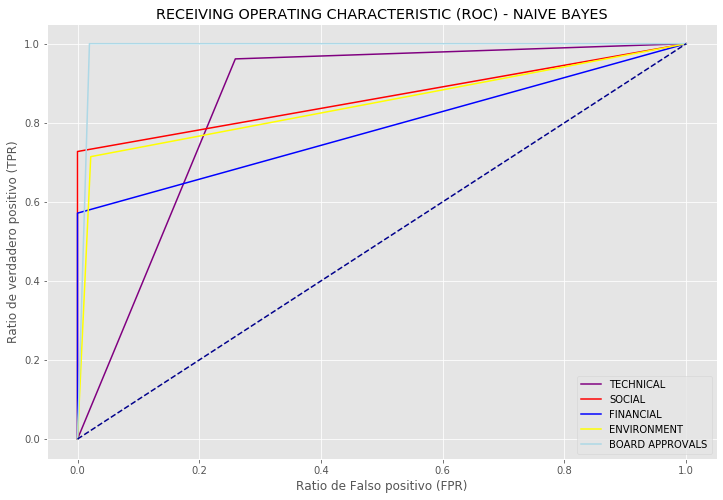

AUC Total:0.850

Technical: 0.851
Social: 0.864
Financial:     0.786
Environmental: 0.846
Board Approvals: 0.990


In [36]:
plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,\
               'RECEIVING OPERATING CHARACTERISTIC (ROC) - NAIVE BAYES')

[VOLVER AL ÍNDICE](#TOP)

<a id='KNN'></a>
<div class="alert alert-block alert-success">

## 4.3 CLASIFICACIÓN CON K-NEAREST NEIGHBORS `KNN`

In [37]:
# buscamos encontrar el valor óptimo de K y visualizamos la precisión para cada valor del parámetro
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
from sklearn.model_selection import cross_val_score
k_range = list(range(1, 31))
k_scores = []
knn.fit(X_train_dtm, y_train) #================================================
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_dtm, y_train, cv=10, scoring='accuracy')
    k_scores.append(round(scores.mean(),2))
print(k_scores)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

[0.87, 0.82, 0.85, 0.84, 0.81, 0.75, 0.73, 0.75, 0.7, 0.68, 0.64, 0.62, 0.62, 0.6, 0.6, 0.6, 0.61, 0.58, 0.58, 0.55, 0.55, 0.53, 0.57, 0.58, 0.59, 0.58, 0.58, 0.58, 0.58, 0.55]


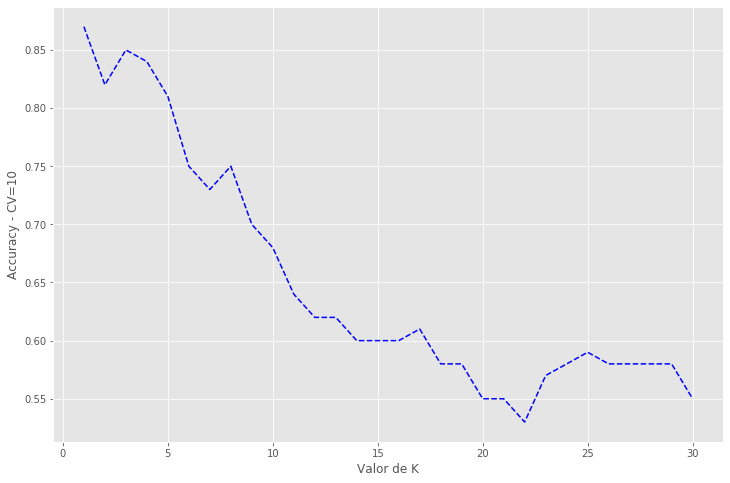

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.plot(k_range, k_scores,color="blue",linestyle='--');
plt.xlabel('Valor de K');
plt.ylabel('Accuracy - CV=10');

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_dtm, y_train)
y_pred_class = knn.predict(X_test_dtm)

# ACCURACY KNN
Accuracy_KNN=round(metrics.accuracy_score(y_test, y_pred_class),4)
print("La clasificación realizada por KNN consigue un `ACCURACY` de {:.1f}%".format(Accuracy_KNN*100))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

La clasificación realizada por KNN consigue un `ACCURACY` de 79.2%


<a id='VCKNN'></a>
<div class="alert alert-block alert-warning">

### 4.3.1 Validación cruzada en `KNN`

In [40]:
# # Validación cruzada con 10 particiones distintas
K=1 # parametro óptimo
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=K)
vcknn = round(cross_val_score(knn, X_train_dtm, y_train, cv=10, scoring='accuracy').mean(),4)
print("La ACCURACY promedio con KNN es {:.1f}%".format(vcknn*100))

La ACCURACY promedio con KNN es 86.7%


<a id='ROCKNN'></a>
<div class="alert alert-block alert-warning">
    
### 4.3.2 Curvas ROC `KNN`

In [41]:
y_test_class_Knn            = y_test.tolist()

y_test_technical            = [1 if x == 'TECHNICAL' else 0 for x in y_test_class_Knn]
y_test_social               = [1 if x == 'SOCIAL' else 0 for x in y_test_class_Knn]
y_test_financial            = [1 if x == 'FINANCIAL' else 0 for x in y_test_class_Knn]
y_test_environmental        = [1 if x == 'ENVIRONMENTAL' else 0 for x in y_test_class_Knn]
y_test_BA                   = [1 if x == 'BOARD APPROVALS' else 0 for x in y_test_class_Knn]

In [42]:
y_pred_class_Knn            = y_pred_class.tolist()

y_pred_class_technical      = [1 if x == 'TECHNICAL' else 0 for x in y_pred_class_Knn]
y_pred_class_social         = [1 if x == 'SOCIAL' else 0 for x in y_pred_class_Knn]
y_pred_class_financial      = [1 if x == 'FINANCIAL' else 0 for x in y_pred_class_Knn]
y_pred_class_environmental  = [1 if x == 'ENVIRONMENTAL' else 0 for x in y_pred_class_Knn]
y_pred_class_BA             = [1 if x == 'BOARD APPROVALS' else 0 for x in y_pred_class_Knn]

In [43]:
a=roc_auc_score(y_test_technical,y_pred_class_technical)
b=roc_auc_score(y_test_social,y_pred_class_social)
c=roc_auc_score(y_test_financial,y_pred_class_financial)
d=roc_auc_score(y_test_environmental,y_pred_class_environmental)
e=roc_auc_score(y_test_BA,y_pred_class_BA)
# f es el AUC total ponderado por el número de veces que se ha predicho esa categoria (correcta o incorrectamente)
f=((a*metrics.confusion_matrix(y_test, y_pred_class)[4,:].sum())\
  +(b*metrics.confusion_matrix(y_test, y_pred_class)[3,:].sum())\
  +(c*metrics.confusion_matrix(y_test, y_pred_class)[2,:].sum())\
  +(d*metrics.confusion_matrix(y_test, y_pred_class)[1,:].sum())\
  +(e*metrics.confusion_matrix(y_test, y_pred_class)[0,:].sum()))\
  /metrics.confusion_matrix(y_test, y_pred_class).sum()
fKNN=f

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_T, tpr_T, threshold     = roc_curve(y_test_technical,y_pred_class_technical)
fpr_S, tpr_S, threshold     = roc_curve(y_test_social,y_pred_class_social)
fpr_F, tpr_F, threshold     = roc_curve(y_test_financial,y_pred_class_financial)
fpr_E, tpr_E, threshold     = roc_curve(y_test_environmental,y_pred_class_environmental)
fpr_BA, tpr_BA, threshold   = roc_curve(y_test_BA,y_pred_class_BA)

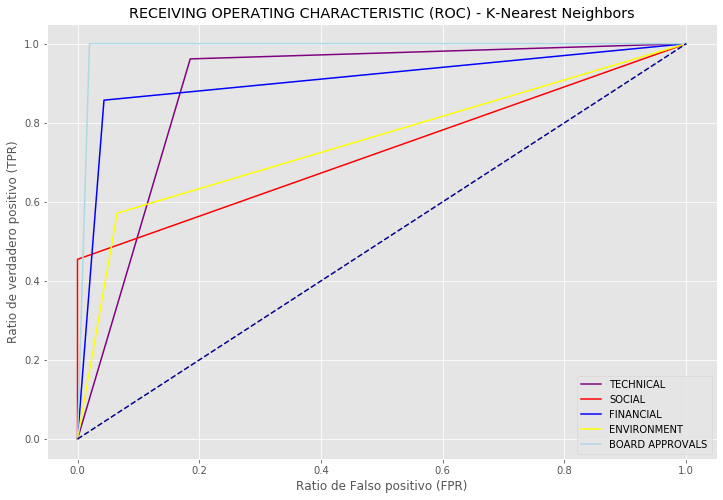

AUC Total:0.843

Technical: 0.888
Social: 0.727
Financial:     0.907
Environmental: 0.753
Board Approvals: 0.990


In [45]:
plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,\
               'RECEIVING OPERATING CHARACTERISTIC (ROC) - K-Nearest Neighbors')

[VOLVER AL ÍNDICE](#TOP)

<a id='RL'></a>
<div class="alert alert-block alert-success">

##  4.4 REGRESIÓN LOGÍSTICA

In [46]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver= 'lbfgs',multi_class='auto',max_iter=3000)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)

# ACCURACY RL
Accuracy_RL=round(metrics.accuracy_score(y_test, y_pred_class),4)
print(f"La clasificación realizada con Regresión Logística consigue un `ACCURACY` de {Accuracy_RL*100:.1f}%")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

La clasificación realizada con Regresión Logística consigue un `ACCURACY` de 83.0%


<a id='VCRL'></a>
<div class="alert alert-block alert-warning">

### 4.4.1 Validación cruzada en Regresión Logística

In [47]:
# 10 particiones distintas
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
vcrl=round(cross_val_score(logreg, X_train_dtm, y_train, cv=10, scoring='accuracy').mean(),4)
print("La ACCURACY promedio con Regresión Logística es {:.1f}%".format(vcrl*100))

La ACCURACY promedio con Regresión Logística es 89.8%


<a id='ROCRL'></a>
<div class="alert alert-block alert-warning">
    
### 4.4.2 CURVAS ROC `Regresión Logística`

In [48]:
y_test_class_RL             = y_test.tolist()

y_test_technical            = [1 if x == 'TECHNICAL' else 0 for x in y_test_class_RL]
y_test_social               = [1 if x == 'SOCIAL' else 0 for x in y_test_class_RL]
y_test_financial            = [1 if x == 'FINANCIAL' else 0 for x in y_test_class_RL]
y_test_environmental        = [1 if x == 'ENVIRONMENTAL' else 0 for x in y_test_class_RL]
y_test_BA                   = [1 if x == 'BOARD APPROVALS' else 0 for x in y_test_class_RL]

In [49]:
y_pred_class_RL              = y_pred_class.tolist()

y_pred_class_technical       = [1 if x == 'TECHNICAL' else 0 for x in y_pred_class_RL]
y_pred_class_social          = [1 if x == 'SOCIAL' else 0 for x in y_pred_class_RL]
y_pred_class_financial       = [1 if x == 'FINANCIAL' else 0 for x in y_pred_class_RL]
y_pred_class_environmental   = [1 if x == 'ENVIRONMENTAL' else 0 for x in y_pred_class_RL]
y_pred_class_BA              = [1 if x == 'BOARD APPROVALS' else 0 for x in y_pred_class_RL]

In [50]:
a=roc_auc_score(y_test_technical,y_pred_class_technical)
b=roc_auc_score(y_test_social,y_pred_class_social)
c=roc_auc_score(y_test_financial,y_pred_class_financial)
d=roc_auc_score(y_test_environmental,y_pred_class_environmental)
e=roc_auc_score(y_test_BA,y_pred_class_BA)
# f es el AUC total ponderado por el número de veces que se ha predicho esa categoria (correcta o incorrectamente)
f=((a*metrics.confusion_matrix(y_test, y_pred_class)[4,:].sum())\
  +(b*metrics.confusion_matrix(y_test, y_pred_class)[3,:].sum())\
  +(c*metrics.confusion_matrix(y_test, y_pred_class)[2,:].sum())\
  +(d*metrics.confusion_matrix(y_test, y_pred_class)[1,:].sum())\
  +(e*metrics.confusion_matrix(y_test, y_pred_class)[0,:].sum()))\
  /metrics.confusion_matrix(y_test, y_pred_class).sum()
fRL=f

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_T, tpr_T, threshold      = roc_curve(y_test_technical,y_pred_class_technical)
fpr_S, tpr_S, threshold      = roc_curve(y_test_social,y_pred_class_social)
fpr_F, tpr_F, threshold      = roc_curve(y_test_financial,y_pred_class_financial)
fpr_E, tpr_E, threshold      = roc_curve(y_test_environmental,y_pred_class_environmental)
fpr_BA, tpr_BA, threshold    = roc_curve(y_test_BA,y_pred_class_BA)

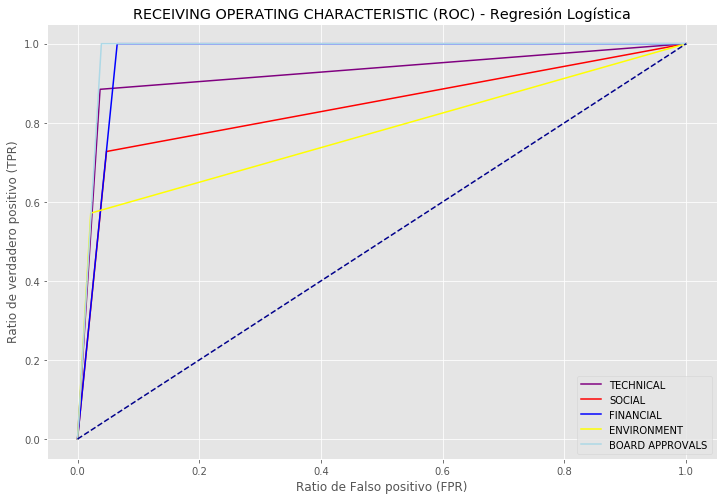

AUC Total:0.895

Technical: 0.924
Social: 0.840
Financial:     0.967
Environmental: 0.775
Board Approvals: 0.980


In [52]:
plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,\
               'RECEIVING OPERATING CHARACTERISTIC (ROC) - Regresión Logística')

[VOLVER AL ÍNDICE](#TOP)

<a id='CUADRORESUMEN'></a>
<div class="alert alert-block alert-info">
    
## 5. CUADRO RESUMEN DE LOS TRES MODELOS

In [53]:
pd.DataFrame({'Multinomial Naive Bayes':[Accuracy_MNB*100,vcmnb*100,fMNB*100],
             'KNN':[Accuracy_KNN*100,vcknn*100,fKNN*100],
             'Regresión Logística':[Accuracy_RL*100,vcrl*100,fRL*100]},
            index=['Accuracy','Accuracy con Validación Cruzada (10-fold)','Area Under The Curve'])

,Multinomial Naive Bayes,KNN,Regresión Logística
Accuracy,83.0%,79.2%,83.0%
Accuracy con Validación Cruzada (10-fold),84.6%,86.7%,89.8%
Area Under The Curve,85.0%,84.3%,89.5%


<a id='PREDICCIONOUTOFSAMPE'></a>
<div class="alert alert-block alert-info">
    
## 6. PREDICCIÓN CON NUEVOS DOCUMENTOS

In [57]:
# Cambiar nuestro directorio de trabajo a aquel en el qué estén los documentos a clasificar
os.chdir('C:/Users/IÑIGO/Documents/WORLDBANK/TEST/VALIDATION')
mypath=os.getcwd()

# crear 2 listas; una con el nombre y extensión de los documentos y otra con su ubicación 'virtual'
import os
List_DocumentsV=[]
ListDirDocumentsV=[]

for (root, directories, filenames) in os.walk(mypath):
    for f in filenames:
                
        List_DocumentsV.append(os.path.join(f))
        List_DocumentsV=list(filter(lambda x: (x.endswith('pdf')), List_DocumentsV))
        
        ListDirDocumentsV.append(os.path.join(root,f).replace('\\','/'))
        ListDirDocumentsV=list(filter(lambda x: (x.endswith('pdf')), ListDirDocumentsV))

# crear otra LISTA CON EL NUMERO DE PAGINAS DE CADA PDF
from PyPDF2 import PdfFileReader
NumberOfPagesListV=[]
for i in range(0,len(ListDirDocumentsV)):
    NumberOfPagesListV.append(PdfFileReader(stream=ListDirDocumentsV[i]).getNumPages()) 

# LISTA CON EL TEXTO DE TODAS LAS PAGINAS DE CADA PDF =lEE 30 PDFs y extrae el texto (335) páginas=
from PyPDF2 import PdfFileReader
TextExtractionListV=[]

for i in range(0,len(ListDirDocumentsV)):
    
    read_pdf=PdfFileReader(ListDirDocumentsV[i])
    number_of_pages = read_pdf.getNumPages()
    for page_number in range(number_of_pages):
        page = read_pdf.getPage(page_number)
        page_content = page.extractText()
        
        TextExtractionListV.append(page_content)
        
# A continuación redimensionamos "TextExtractionListV" de 335 elementos a 30
TELV = []
c = 0
for np in NumberOfPagesListV:       
    LPV = TextExtractionListV[c:c+np]
    c+= np
    TELV.append(LPV)
    
# Modificamos TELV para que todos sus elementos sean una única cadena de texto
TELstrV=[] #===========================
for i in range(len(TELV)):
    TELstrV.append(" ".join(TELV[i]))

# Combinar toda la información extraida hasta ahora en una nueva Matriz "pandas" df1V
import pandas as pd
df1V=pd.DataFrame({'Documento':List_DocumentsV,
                  'Num.Páginas':NumberOfPagesListV,
                  'AllRawTextV':TELstrV})

# feature selection
# creamos una nueva Matriz añadiendo una columna nueva con el texto depurado de todos los caracteres que no sean letras
# a continuación procesamos los tokens resultantes extrayendo sus 'raíces' - "Stemming"
from nltk.stem import SnowballStemmer
stemmer=SnowballStemmer("english")
from nltk.corpus import stopwords
WordsStoped=stopwords.words("english")

import re # un poco de REGEX
#eliminar todo que no sea texto
SoloTexto = re.compile(r'[^a-zA-Z]')
df1V['Texto+LimpioV']=df1V.AllRawTextV.apply(lambda col: " ".join(SoloTexto.sub(' ',col).split()))
#eliminar tokens con tres o menos palabras
ShortWordsV = re.compile(r'\W*\b\w{1,3}\b')
df1V['Texto+LimpioV']=df1V['Texto+LimpioV'].apply(lambda col: " ".join(ShortWordsV.sub('',col).split()))
#extracción de raices
df1V['Texto+LimpioV']=df1V['Texto+LimpioV'].apply\
(lambda x: " ".join([stemmer.stem(i) for i in x.split() if i not in WordsStoped]).lower())
df1V.head(1)

,Documento,Num.Páginas,AllRawTextV,Texto+LimpioV
0,Appraisal_ISDS_SSFM_TECHNICAL.pdf,11,"Page 1 of 11Public Disclosure CopyPublic Disclosure CopyINTEGRATED SAFEGUARDS DATA SHEET APPRAISAL STAGEReport No.: ISDSA8281Date ISDS Prepared/Updated:10-May-2014Date ISDS Approved/Disclosed:20-May-2014I.BASIC INFORMATION 1. Basic Project DataCountry:PhilippinesProject ID: P145391Project Name: Studies for Sustainable Flood Mgmt. (P145391)Task Team Leader: Joop StoutjesdijkEstimated \nAppraisal Date:15-Apr-2014Estimated \nBoard Date: 31-Dec-2015Managing Unit:EASPSLending \nInstrument: Specific Investment LoanSector(s):Flood protection (100%)Theme(s):Water resource management (70%), Natural disaster management (30%)Is this project processed under OP 8.50 (Emergency Recovery) or OP \n8.00 (Rapid Response to Crises and Emergencies)?NoFinancing (In USD Million)Total Project Cost:7.00Total Bank Financing:0.00Financing Gap:0.00Financing SourceAmountBorrower0.00Philippines - Free-standing Trust Fund Program7.00Total7.00Environmental \nCategory:A - Full AssessmentIs this a \nRepeater \n...",page public disclosur copypubl disclosur copyintegr safeguard data sheet apprais stagereport isdsa date isd prepar updat date isd approv disclos basic inform basic project datacountri philippinesproject project name studi sustain flood mgmt task team leader joop stoutjesdijkestim apprais date estim board date manag unit easpslend instrument specif invest loansector flood protect theme water resourc manag natur disast manag project process emerg recoveri rapid respons crise emerg nofinanc million total project cost total bank financ financ financ sourceamountborrow philippin free stand trust fund program total environment categori full assessmenti repeat project project develop object propos develop object prepar prioriti project improv flood manag resili greater metro manila area project descriptionth recent approv metro manila flood manag master plan propos larg program prioriti infrastructur safe manag control major flood event greater metro manila public disclosur author public ...


In [58]:
# PASO 9
# vector de 'features' de la matriz de validación
X_v=df1V['Texto+LimpioV']

# transformar datos de validación en un document-term matrix
X_v_dtm = vect.transform(X_v)
X_v_dtm.toarray()
X_v_dtm.shape

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

(30, 5723)

In [59]:
# Visualizar juntos vocabulario y document-term matrix 
dfvalid=pd.DataFrame(X_v_dtm.toarray(),
                     columns=vect.get_feature_names())
dfvalid.head()
dfvalid.shape

,abad,abandon,abat,abbrevi,abdomin,abil,abl,abnorm,abov,abovement,...,young,youth,ystem,zamboanga,zapot,zeal,zero,zinc,zonal,zone
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


(30, 5723)

In [60]:
# muestra solo las columnas que tienen al menos un token presente en algún documento nuevo
dfvalid.loc[:,lambda df: df.sum() > 0].head()

,abad,abbrevi,abil,abl,abov,abovement,absent,absorb,absorpt,acc,...,worldbank,worsen,write,written,xiii,year,yield,yolanda,zero,zone
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,2,0,0,0,0,...,2,0,0,1,1,8,0,0,0,0
2,1,0,0,2,0,0,0,0,0,0,...,9,0,1,1,0,0,0,0,0,0
3,0,0,0,5,0,0,0,0,0,0,...,10,0,2,1,0,0,0,0,0,0
4,1,0,1,0,0,2,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0


In [61]:
# IMPORTAMOS EL FICHERO con la clasificación manual del conjunto de validación
import os
os.chdir('C:/Users/IÑIGO/Documents/InfoNoEstructurada_ProcesamientoLenguajeNatural_TextMining/TRABAJO FIN DE MASTER')
import pandas as pd
ValidationDF=pd.read_excel('World_Bank_Documents_Classification_P.xlsm',
                        sheet_name='VALIDATION',
                        usecols=[1,2])
ValidationDF.head()

,Name,Type
0,Appraisal_ISDS_SSFM_TECHNICAL.pdf,TECHNICAL
1,Audit_Report_Studies_for_SSFM_FINANCIAL.pdf,FINANCIAL
2,DisbursementLetter_CADMRWM_20151012_FINANCIAL.pdf,FINANCIAL
3,DisbursementLetter_Grant_SSFM_FINANCIAL.pdf,FINANCIAL
4,GrantAgreement_CADMRWM - 20151012_FINANCIAL.pdf,FINANCIAL


In [62]:
# ===es necesario volver a ejecutar el 'entrenamiento' del algoritmo===aunque los modelos ya han sido "fitted" previamente===
nb.fit(X_train_dtm, y_train)
knn.fit(X_train_dtm, y_train)
logreg.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
# predicción
y_pred_validation_mnb = nb.predict(X_v_dtm)
y_pred_validation_knn = knn.predict(X_v_dtm)
y_pred_validation_rl = logreg.predict(X_v_dtm)

In [64]:
# accuracy..contrastar la verdadera categoria con la predicha
accu_v_mnb=round(metrics.accuracy_score(ValidationDF.Type, y_pred_validation_mnb),4)
accu_v_knn=round(metrics.accuracy_score(ValidationDF.Type, y_pred_validation_knn),4)
accu_v_rl=round(metrics.accuracy_score(ValidationDF.Type, y_pred_validation_rl),4)

pd.DataFrame({'Multinomial Naive Bayes':[accu_v_mnb*100],
             'K-NearestNeighbors':[accu_v_knn*100],
             'Regresión Logística':[accu_v_rl*100]},
             index=['Accuracy Bloque Validación'])

,Multinomial Naive Bayes,K-NearestNeighbors,Regresión Logística
Accuracy Bloque Validación,70.0%,76.7%,80.0%


In [65]:
# comprobación intuitiva del accuracy calculado por scikit-learn
cmprtv=pd.DataFrame(data={'Predicción_MNB':y_pred_validation_mnb,
                               'Predicción_KNN':y_pred_validation_knn,
                              'Predicción_RL':y_pred_validation_rl,
                              'Categoria':ValidationDF.Type})

cmprtv['¿Son_Iguales_MNB?'] =cmprtv.apply(lambda Col: Col['Categoria'] in Col['Predicción_MNB'], axis=1)
accurR_mnb=cmprtv['¿Son_Iguales_MNB?'].sum()/len(cmprtv['¿Son_Iguales_MNB?'])

cmprtv['¿Son_Iguales_KNN?'] =cmprtv.apply(lambda Col: Col['Categoria'] in Col['Predicción_KNN'], axis=1)
accurR_knn=cmprtv['¿Son_Iguales_KNN?'].sum()/len(cmprtv['¿Son_Iguales_KNN?'])

cmprtv['¿Son_Iguales_RL?'] =cmprtv.apply(lambda Col: Col['Categoria'] in Col['Predicción_RL'], axis=1)
accurR_rl=cmprtv['¿Son_Iguales_RL?'].sum()/len(cmprtv['¿Son_Iguales_RL?'])

pd.DataFrame({'Multinomial Naive Bayes':[accurR_mnb*100],
             'K-NearestNeighbors':[accurR_knn*100],
             'Regresión Logística':[accurR_rl*100]},
             index=['Accuracy - Verificación de Resultados'])
cmprtv.head(2)

,Multinomial Naive Bayes,K-NearestNeighbors,Regresión Logística
Accuracy - Verificación de Resultados,70.0%,76.7%,80.0%


,Predicción_MNB,Predicción_KNN,Predicción_RL,Categoria,¿Son_Iguales_MNB?,¿Son_Iguales_KNN?,¿Son_Iguales_RL?
0,TECHNICAL,TECHNICAL,TECHNICAL,TECHNICAL,True,True,True
1,FINANCIAL,FINANCIAL,FINANCIAL,FINANCIAL,True,True,True


In [66]:
metrics.confusion_matrix(ValidationDF.Type, y_pred_validation_mnb)
metrics.confusion_matrix(ValidationDF.Type, y_pred_validation_knn)
metrics.confusion_matrix(ValidationDF.Type, y_pred_validation_rl)

array([[ 2,  9],
       [ 0, 19]], dtype=int64)

array([[ 0,  0,  0],
       [ 1,  5,  5],
       [ 1,  0, 18]], dtype=int64)

array([[ 0,  0,  0],
       [ 1,  5,  5],
       [ 0,  0, 19]], dtype=int64)

In [67]:
print(classification_report(ValidationDF.Type,y_pred_validation_mnb))

              precision    recall  f1-score   support

   FINANCIAL       1.00      0.18      0.31        11
   TECHNICAL       0.68      1.00      0.81        19

    accuracy                           0.70        30
   macro avg       0.84      0.59      0.56        30
weighted avg       0.80      0.70      0.62        30



In [68]:
print(classification_report(ValidationDF.Type,y_pred_validation_knn))

                 precision    recall  f1-score   support

BOARD APPROVALS       0.00      0.00      0.00         0
      FINANCIAL       1.00      0.45      0.62        11
      TECHNICAL       0.78      0.95      0.86        19

       accuracy                           0.77        30
      macro avg       0.59      0.47      0.49        30
   weighted avg       0.86      0.77      0.77        30



In [69]:
print(classification_report(ValidationDF.Type,y_pred_validation_rl))

                 precision    recall  f1-score   support

BOARD APPROVALS       0.00      0.00      0.00         0
      FINANCIAL       1.00      0.45      0.62        11
      TECHNICAL       0.79      1.00      0.88        19

       accuracy                           0.80        30
      macro avg       0.60      0.48      0.50        30
   weighted avg       0.87      0.80      0.79        30



[VOLVER AL ÍNDICE](#TOP)

<a id='NOSUPERVISADO'></a>
<div class="alert alert-block alert-info">


# 7. APRENDIZAJE NO SUPERVISADO (K-Means)

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.85,stop_words='english')
XX = vectorizer.fit_transform(X)
from sklearn.cluster import MiniBatchKMeans
categorias = 5
kmeans = MiniBatchKMeans(n_clusters=categorias,
               init='k-means++',
               max_iter=100,
               n_init=1)
kmeans.fit(XX)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
features = vectorizer.get_feature_names()

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [77]:
lista1=[]
n=10
for i in range(0,len(order_centroids)):
    for j in range(n):
        lista1.append(features[order_centroids[i][j]])

lista2 = [lista1[i * n:(i + 1) * n] for i in range((len(lista1) + n - 1) // n )]
import pandas as pd
dfcluster=pd.DataFrame(data={'Cluster 1':lista2[0],
                             'Cluster 2':lista2[1],
                             'Cluster 3':lista2[2],
                             'Cluster 4':lista2[3],
                             'Cluster 5':lista2[4]},index=range(1,n+1))
dfcluster

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
1,reportcebu,irrig,pump,baselineactu,asset
2,baselineactu,bank,station,targetvalu,statement
3,targetvalu,environment,flood,actual,cash
4,bankimplement,area,wast,custom,financi
5,custom,shall,impact,previous,parent
6,rapid,land,resettl,current,liabil
7,actual,impact,manila,bankimplement,compani
8,transit,water,area,wastewat,account
9,previous,includ,waterway,moder,decemb
10,copypubl,resettl,drainag,irrig,recogn
